# Reading Data

In [1]:
base_path = "drive/MyDrive/Datasets/Earthquake"

In [2]:
!ls -lha $base_path

total 465K
-rw------- 1 root root 1.9K Jun 17 10:08 Earthquake_Qazvin.txt
-rw------- 1 root root 2.1K Jun 17 10:08 Earthquake_Tehran.txt
drwx------ 2 root root 4.0K Jun 18 08:54 iran_sections
-rw------- 1 root root 457K Jun 17 10:09 StationTable.html


In [3]:
!pip install -U geopandas > /dev/null
!apt-get install libspatialindex-dev > /dev/null
!pip install -U rtree > /dev/null
!pip install -U pygeos > /dev/null

In [4]:
import pandas as pd
import geopandas as gpd

tehran_earthquakes = pd.read_csv(f"{base_path}/Earthquake_Tehran.txt", sep="\t", skiprows=[1])
qazvin_earthquakes = pd.read_csv(f"{base_path}/Earthquake_Qazvin.txt", sep="\t", skiprows=[1])
earthquakes = pd.concat([tehran_earthquakes, qazvin_earthquakes]).drop_duplicates()
earthquakes.columns = ["DateTime", "Lat", "Long", "Depth", "Mag"]
earthquakes = gpd.GeoDataFrame(earthquakes, geometry=gpd.points_from_xy(earthquakes["Long"], earthquakes["Lat"]), crs="epsg:4326")
earthquakes.head()

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


,DateTime,Lat,Long,Depth,Mag,geometry
0,2020-06-02_09:15:51,35.784,52.045,12.1,2.9,POINT (52.04500 35.78400)
1,2020-06-01_14:21:16,35.785,52.013,10.6,2.6,POINT (52.01300 35.78500)
2,2020-06-01_11:13:54,37.244,53.975,10.0,2.6,POINT (53.97500 37.24400)
3,2020-06-01_01:04:36,35.631,52.622,9.2,2.9,POINT (52.62200 35.63100)
4,2020-05-31_01:38:48,36.417,51.320,15.4,3.0,POINT (51.32000 36.41700)


In [5]:
earthquakes['Lat'] = pd.to_numeric(earthquakes['Lat'])
earthquakes['Long'] = pd.to_numeric(earthquakes['Long'])
earthquakes['Depth'] = pd.to_numeric(earthquakes['Depth'])
earthquakes['Mag'] = pd.to_numeric(earthquakes['Mag'])

In [6]:
stations = pd.read_html(f"{base_path}/StationTable.html", header=0)[0].drop(columns=["No"])
stations.columns = ["SubNetwork", "Code", "Name", "Lat", "Long", "Alt"]
stations = stations[stations["SubNetwork"].isin(["Tehran", "Qazvin"])]
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations["Long"], stations["Lat"]), crs="epsg:4236")
stations.head()

,SubNetwork,Code,Name,Lat,Long,Alt,geometry
52,Qazvin,QABG,Abgarm,35.708,49.582,2085.0,POINT (49.58200 35.70800)
53,Qazvin,QALM,Alamut,36.432,50.646,2212.0,POINT (50.64600 36.43200)
54,Qazvin,QCNT,Center,36.290,50.009,1319.0,POINT (50.00900 36.29000)
55,Qazvin,QSDN,Sirdan,36.504,49.174,2148.0,POINT (49.17400 36.50400)
97,Tehran,DMV,Damavand,35.577,52.032,2546.0,POINT (52.03200 35.57700)


# Map

In [7]:
import folium # well-known package for making interactive maps based on openstreet maps; there are some other packages to handle huge data on WebGL
from folium import Choropleth, Circle, Marker, Icon
from folium.plugins import HeatMap, MarkerCluster
from folium import GeoJson

In [8]:
m_1 = folium.Map(location=[35.7, 51.3], tiles="cartodbpositron", zoom_start=8)
m_1

In [9]:
for _, row in stations.iterrows():
    folium.Marker([row["Lat"], row["Long"]], popup=row["Name"], icon=folium.Icon("blue")).add_to(m_1)

m_1

In [10]:
for _, row in earthquakes.iterrows():
    folium.Marker([row["Lat"], row["Long"]], popup=row["DateTime"], icon=folium.Icon("red")).add_to(m_1)

m_1

In [11]:
nearest_stations = []
nearest_distances = []
for ind, row in earthquakes.iterrows():
    distances = stations.geometry.distance(row.geometry)
    nearest_stations.append(stations.iloc[distances.argmin()])
    nearest_distances.append(distances.min())
nearest_stations = gpd.GeoDataFrame(nearest_stations)
nearest_stations["distance"] = nearest_distances
nearest_stations.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,SubNetwork,Code,Name,Lat,Long,Alt,geometry,distance
97,Tehran,DMV,Damavand,35.577,52.032,2546.0,POINT (52.03200 35.57700),0.207408
97,Tehran,DMV,Damavand,35.577,52.032,2546.0,POINT (52.03200 35.57700),0.208866
98,Tehran,FIR,Firuzkuh,35.642,52.754,2380.0,POINT (52.75400 35.64200),2.014260
98,Tehran,FIR,Firuzkuh,35.642,52.754,2380.0,POINT (52.75400 35.64200),0.132458
105,Tehran,TEH,Tehran,35.752,51.389,1458.0,POINT (51.38900 35.75200),0.668570


In [12]:
m_2 = folium.Map(location=[35.7, 51.3], tiles="cartodbpositron", zoom_start=8)

for idx, row in earthquakes.iterrows():
    folium.Marker([row["Lat"], row["Long"]], popup=nearest_stations.iloc[idx]["Name"], icon=folium.Icon("red")).add_to(m_2)

m_2

# Heatmap

In [13]:
m_3 = folium.Map(location=[35.7, 51.3], tiles="cartodbpositron", zoom_start=8)

HeatMap(data=[(row["Lat"], row["Long"], (row["Mag"] / row["Depth"])) for _, row in earthquakes.iterrows()], radius=30).add_to(m_3)

m_3

# Finding point with maximum distance to nearest station in Tehran

In [14]:
sections = gpd.read_file(f"{base_path}/iran_sections/irn_admbnda_adm1_unhcr_20190514.shp")
sections.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_FA,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1FA,ADM1ALT2FA,ADM0_EN,ADM0_FA,ADM0_PCODE,date,validOn,validTo,geometry
0,4.346753,0.523109,Alborz,البرز‎,IR001,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((50.49594 36.34221, 50.50150 36.34166..."
1,10.218890,1.845273,Ardabil,اردبیل,IR002,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((48.03206 39.69253, 48.09512 39.63819..."
2,16.019141,2.088545,Bushehr,بوشهر,IR003,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"MULTIPOLYGON (((51.41462 27.90553, 51.41510 27..."
3,7.087819,1.555897,Chaharmahal and Bakhtiari,چهارمحال و بختیاری,IR004,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((49.72980 32.80907, 49.73119 32.80851..."
4,14.145806,4.646606,East Azerbaijan,آذربایجان شرقی,IR005,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((47.36634 39.41979, 47.37967 39.40590..."


In [15]:
tehran_area = sections[sections["ADM1_EN"] == "Tehran"]

In [16]:
tehran_stations = gpd.sjoin(tehran_area, stations)
tehran_stations.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4236

  """Entry point for launching an IPython kernel.


,Shape_Leng,Shape_Area,ADM1_EN,ADM1_FA,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1FA,ADM1ALT2FA,ADM0_EN,ADM0_FA,ADM0_PCODE,date,validOn,validTo,geometry,index_right,SubNetwork,Code,Name,Lat,Long,Alt
27,8.261077,1.353262,Tehran,تهران,IR028,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((51.59433 36.08609, 51.59794 36.08415...",100,Tehran,HSB,HasanAbad,35.438,51.276,1138.0
27,8.261077,1.353262,Tehran,تهران,IR028,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((51.59433 36.08609, 51.59794 36.08415...",97,Tehran,DMV,Damavand,35.577,52.032,2546.0
27,8.261077,1.353262,Tehran,تهران,IR028,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((51.59433 36.08609, 51.59794 36.08415...",98,Tehran,FIR,Firuzkuh,35.642,52.754,2380.0
27,8.261077,1.353262,Tehran,تهران,IR028,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((51.59433 36.08609, 51.59794 36.08415...",107,Tehran,TEHA,AmirAbad,35.746,51.387,1418.0
27,8.261077,1.353262,Tehran,تهران,IR028,None,None,None,None,None,Iran (Islamic Republic of),ایران (جمهوری اسلامی),IR,2019-04-09,2019-05-14,None,"POLYGON ((51.59433 36.08609, 51.59794 36.08415...",105,Tehran,TEH,Tehran,35.752,51.389,1458.0


In [17]:
m_4 = folium.Map(location=[35.7,51.3], tiles='cartodbpositron', zoom_start=9)

# Add points to the map
for idx, row in tehran_stations.iterrows():
    Marker([row['Lat'], row['Long']], popup=row['Name']).add_to(m_4)

for idx, row in tehran_stations.iterrows():
    vers = []
    for p in row['geometry'].exterior.coords:
        q = (p[1], p[0])
        vers.append(q)
    m_4.add_child(folium.vector_layers.Polygon(vers, popup=row['ADM1_EN']))
    
m_4

finding points that have maximum distance with nearest some centroids is equal to finding voronoi boundaries on these centroids

In [18]:
from math import cos, pi

lat_factor = 0.110574
lon_factor = 0.111320

def spatial_to_xy(lat, lon):
    x = lat_factor * lat
    y = lon_factor * cos((pi * lat) / 180) * lon
    return x, y

def xy_to_spatial(x, y):
    lat = x / lat_factor
    lon = y / (lon_factor * cos((pi * lat) / 180))
    return lat, lon

In [19]:
from scipy.spatial import Voronoi, voronoi_plot_2d

xy_points = [spatial_to_xy(row["Lat"], row["Long"]) for _, row in tehran_stations.iterrows()]
vor = Voronoi(xy_points, qhull_options='Qbb Qc Qx')

In [20]:
spatial_vertices = [xy_to_spatial(x, y) for x, y in vor.vertices]
spatial_vertices

[(31.41382968952219, 50.482143921749625),
 (37.11770417118941, 53.198688283203595),
 (34.07988339077057, 42.509145419360465),
 (35.654346666272566, 51.702758589723494),
 (35.84043485399966, 51.88622032980367)]

In [21]:
vor.regions

[[1, -1, 0], [4, 2, 3], [4, 1, -1, 2], [3, 0, -1, 2], [4, 1, 0, 3]]

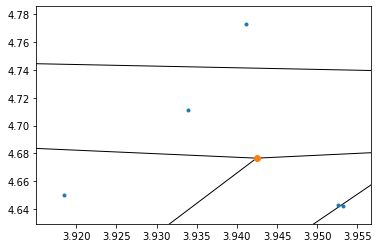

In [22]:
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()

# Finding new station location

In [23]:
m_5 = folium.Map(location=[35.7,51.3], tiles='cartodbpositron', zoom_start=8)

earthquakes_buffer = gpd.GeoDataFrame(
    earthquakes.drop(['geometry'], axis=1),
    geometry=earthquakes.to_crs(epsg=3763).geometry.buffer(25000).to_crs(epsg=4326)
)
union_earthquakes_buffer = earthquakes_buffer.geometry.unary_union
GeoJson(union_earthquakes_buffer, style_function=lambda feature: {
    'fillColor': 'red',
    'color' : 'red'
}).add_to(m_5)


stations_buffer = gpd.GeoDataFrame(
    stations.drop(['geometry'], axis=1),
    geometry=stations.to_crs(epsg=3763).geometry.buffer(50000).to_crs(epsg=4326)
)
union_stations_buffer = stations_buffer.geometry.unary_union
GeoJson(union_stations_buffer, style_function=lambda feature: {
    'fillColor': 'blue',
    'color' : 'blue'
}).add_to(m_5)

m_5

In [24]:
m_6 = folium.Map(location=[35.7, 51.3], tiles='cartodbpositron', zoom_start=8)

GeoJson(union_earthquakes_buffer - union_stations_buffer, style_function=lambda feature: {
    'fillColor': 'orange',
    'color' : 'orange'
}).add_to(m_6)

m_6

In [25]:
for _, row in earthquakes.iterrows():
    folium.Marker([row["Lat"], row["Long"]], popup=row["DateTime"], icon=folium.Icon("red")).add_to(m_6)

m_6

in near Qom, we have four earthquakes in an area that there isn't any station near these points and if we set a new station between of them, all of these earthquakes are covered by this new station.